In [40]:
import torch
import pandas as pd
from torch import nn
from torch import optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import numpy as np
import random
import timeit
from tqdm import tqdm

In [50]:
RANDOM_SEED = 42
BATCH_SIZE = 512
EPOCHS = 40
LEARNING_RATE = 1e-4
NUM_CLASSES = 10
PATCH_SIZE = 4
IMG_SIZE = 28
IN_CHANNELS = 1
NUM_HEADS = 8
DROPOUT = 0.001
HIDDEN_DIM = 768
ADAM_WEIGHT_DECAY = 0.1
ADAM_BETAS = (0.9, 0.999)
ACTIVATION="gelu"
NUM_ENCODERS = 4
EMBED_DIM = (PATCH_SIZE ** 2) * IN_CHANNELS # 16
NUM_PATCHES = (IMG_SIZE // PATCH_SIZE) ** 2 # 49

random.seed(RANDOM_SEED)
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed(RANDOM_SEED)
torch.cuda.manual_seed_all(RANDOM_SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [42]:
class PatchEmbedding(nn.Module):
    def __init__(self, embed_dim, patch_size, num_patches, dropout, in_channels):
        super().__init__()
        self.patcher = nn.Sequential(
            nn.Conv2d(
                in_channels=in_channels,
                out_channels=embed_dim,
                kernel_size=patch_size,
                stride=patch_size,
            ),
            nn.Flatten(2))

        self.cls_token = nn.Parameter(torch.randn(size=(1, in_channels, embed_dim)), requires_grad=True)
        self.position_embeddings = nn.Parameter(torch.randn(size=(1, num_patches+1, embed_dim)), requires_grad=True)
        self.dropout = nn.Dropout(p=dropout)

    def forward(self, x):
        cls_token = self.cls_token.expand(x.shape[0], -1, -1)

        x = self.patcher(x).permute(0, 2, 1)
        x = torch.cat([cls_token, x], dim=1)
        x = self.position_embeddings + x
        x = self.dropout(x)
        return x

model = PatchEmbedding(EMBED_DIM, PATCH_SIZE, NUM_PATCHES, DROPOUT, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape)


torch.Size([512, 50, 16])


In [43]:
class ViT(nn.Module):
    def __init__(self, num_patches, img_size, num_classes, patch_size, embed_dim, num_encoders, num_heads, hidden_dim, dropout, activation, in_channels):
        super().__init__()
        self.embeddings_block = PatchEmbedding(embed_dim, patch_size, num_patches, dropout, in_channels)

        encoder_layer = nn.TransformerEncoderLayer(d_model=embed_dim, nhead=num_heads, dropout=dropout, activation=activation, batch_first=True, norm_first=True)
        self.encoder_blocks = nn.TransformerEncoder(encoder_layer, num_layers=num_encoders)

        self.mlp_head = nn.Sequential(
            nn.LayerNorm(normalized_shape=embed_dim),
            nn.Linear(in_features=embed_dim, out_features=num_classes)
        )

    def forward(self, x):
        x = self.embeddings_block(x)
        x = self.encoder_blocks(x)
        x = self.mlp_head(x[:, 0, :])  # Apply MLP on the CLS token only
        return x

model = ViT(NUM_PATCHES, IMG_SIZE, NUM_CLASSES, PATCH_SIZE, EMBED_DIM, NUM_ENCODERS, NUM_HEADS, HIDDEN_DIM, DROPOUT, ACTIVATION, IN_CHANNELS).to(device)
x = torch.randn(512, 1, 28, 28).to(device)
print(model(x).shape) # BATCH_SIZE X NUM_CLASSES


torch.Size([512, 10])


/usr/local/lib/python3.10/dist-packages/torch/nn/modules/transformer.py:379: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Use the Kaggle api to download the digit recognizer. Login to the kaggle, generate a temporary api token and add it into files section and run the following command to download the dataset.

In [10]:
!pip3 install kaggle

In [30]:
!mkdir -p ~/.kaggle

!cp kaggle.json /root/.config/kaggle/kaggle.json

!chmod 600 /root/.config/kaggle/kaggle.json

In [31]:
import kaggle

In [23]:
!kaggle competitions download -c digit-recognizer

 78% 12.0M/15.3M [00:00<00:00, 21.2MB/s]
100% 15.3M/15.3M [00:00<00:00, 16.4MB/s]


In [24]:
!unzip digit-recognizer.zip

Archive:  digit-recognizer.zip
  inflating: sample_submission.csv   
  inflating: test.csv                
  inflating: train.csv               


In [29]:
train_df = pd.read_csv("train.csv")
test_df = pd.read_csv("test.csv")
submission_df = pd.read_csv("sample_submission.csv")
train_df.head()
test_df.head()
submission_df.head()
train_df, val_df = train_test_split(train_df, test_size=0.1, random_state=RANDOM_SEED, shuffle=True)


In [32]:
class MNISTTrainDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToPILImage(),
            transforms.RandomRotation(15),
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTValDataset(Dataset):
    def __init__(self, images, labels, indicies):
        self.images = images
        self.labels = labels
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        label = self.labels[idx]
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "label": label, "index": index}

class MNISTSubmitDataset(Dataset):
    def __init__(self, images, indicies):
        self.images = images
        self.indicies = indicies
        self.transform = transforms.Compose([
            transforms.ToTensor(),
            transforms.Normalize([0.5], [0.5])
        ])

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        image = self.images[idx].reshape((28, 28)).astype(np.uint8)
        index = self.indicies[idx]
        image = self.transform(image)

        return {"image": image, "index": index}


Total training data 37800
------------------------------
Total Validation data 4200
------------------------------
Total Test data 28000
------------------------------


<Figure size 640x480 with 0 Axes>

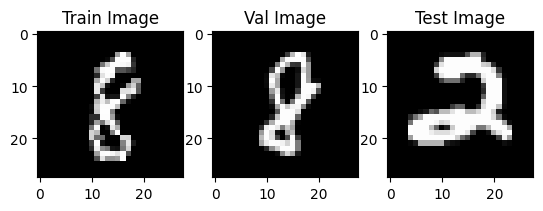

In [35]:
plt.figure()
f, axarr = plt.subplots(1, 3)

train_dataset = MNISTTrainDataset(train_df.iloc[:, 1:].values.astype(np.uint8), train_df.iloc[:, 0].values, train_df.index.values)
print("Total training data" , len(train_dataset))
axarr[0].imshow(train_dataset[0]["image"].squeeze(), cmap="gray")
axarr[0].set_title("Train Image")
print("-"*30)

val_dataset = MNISTValDataset(val_df.iloc[:, 1:].values.astype(np.uint8), val_df.iloc[:, 0].values, val_df.index.values)
print("Total Validation data" , len(val_dataset))
axarr[1].imshow(val_dataset[0]["image"].squeeze(), cmap="gray")
axarr[1].set_title("Val Image")
print("-"*30)

test_dataset = MNISTSubmitDataset(test_df.values.astype(np.uint8), test_df.index.values)
print("Total Test data" , len(test_dataset))
axarr[2].imshow(test_dataset[0]["image"].squeeze(), cmap="gray")
axarr[2].set_title("Test Image")
print("-"*30)

plt.show()


In [36]:
train_dataloader = DataLoader(dataset=train_dataset,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

val_dataloader = DataLoader(dataset=val_dataset,
                            batch_size=BATCH_SIZE,
                            shuffle=True)

test_dataloader = DataLoader(dataset=test_dataset,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

In [52]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), betas=ADAM_BETAS, lr=LEARNING_RATE, weight_decay=ADAM_WEIGHT_DECAY)

start = timeit.default_timer()
for epoch in tqdm(range(EPOCHS), position=0, leave=True):
    model.train()
    train_labels = []
    train_preds = []
    train_running_loss = 0
    for idx, img_label in enumerate(tqdm(train_dataloader, position=0, leave=True)):
        img = img_label["image"].float().to(device)
        label = img_label["label"].type(torch.uint8).to(device)
        y_pred = model(img)
        y_pred_label = torch.argmax(y_pred, dim=1)

        train_labels.extend(label.cpu().detach())
        train_preds.extend(y_pred_label.cpu().detach())

        loss = criterion(y_pred, label)

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
    train_loss = train_running_loss / (idx + 1)

    model.eval()
    val_labels = []
    val_preds = []
    val_running_loss = 0
    with torch.no_grad():
        for idx, img_label in enumerate(tqdm(val_dataloader, position=0, leave=True)):
            img = img_label["image"].float().to(device)
            label = img_label["label"].type(torch.uint8).to(device)
            y_pred = model(img)
            y_pred_label = torch.argmax(y_pred, dim=1)

            val_labels.extend(label.cpu().detach())
            val_preds.extend(y_pred_label.cpu().detach())

            loss = criterion(y_pred, label)
            val_running_loss += loss.item()
    val_loss = val_running_loss / (idx + 1)

    print("-"*30)
    print(f"Train Loss EPOCH {epoch+1}: {train_loss:.4f}")
    print(f"Valid Loss EPOCH {epoch+1}: {val_loss:.4f}")
    print(f"Train Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(train_preds, train_labels) if x == y) / len(train_labels):.4f}")
    print(f"Valid Accuracy EPOCH {epoch+1}: {sum(1 for x,y in zip(val_preds, val_labels) if x == y) / len(val_labels):.4f}")
    print("-"*30)



stop = timeit.default_timer()
print(f"Training Time: {stop-start:.2f}s")


100%|██████████| 9/9 [00:00<00:00,  9.04it/s]


------------------------------
Train Loss EPOCH 1: 1.5920
Valid Loss EPOCH 1: 1.4018


  2%|▎         | 1/40 [00:23<14:59, 23.06s/it]

Train Accuracy EPOCH 1: 0.4720
Valid Accuracy EPOCH 1: 0.5860
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.36it/s]


------------------------------
Train Loss EPOCH 2: 1.4677
Valid Loss EPOCH 2: 1.3595


  5%|▌         | 2/40 [00:45<14:23, 22.74s/it]

Train Accuracy EPOCH 2: 0.5335
Valid Accuracy EPOCH 2: 0.6160
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.33it/s]


------------------------------
Train Loss EPOCH 3: 1.4419
Valid Loss EPOCH 3: 1.3117


  8%|▊         | 3/40 [01:07<13:53, 22.52s/it]

Train Accuracy EPOCH 3: 0.5522
Valid Accuracy EPOCH 3: 0.6369
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.92it/s]


------------------------------
Train Loss EPOCH 4: 1.4330
Valid Loss EPOCH 4: 1.3570


 10%|█         | 4/40 [01:29<13:25, 22.37s/it]

Train Accuracy EPOCH 4: 0.5525
Valid Accuracy EPOCH 4: 0.6190
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


------------------------------
Train Loss EPOCH 5: 1.4284
Valid Loss EPOCH 5: 1.3445


 12%|█▎        | 5/40 [01:52<12:58, 22.25s/it]

Train Accuracy EPOCH 5: 0.5553
Valid Accuracy EPOCH 5: 0.5990
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.08it/s]


------------------------------
Train Loss EPOCH 6: 1.4190
Valid Loss EPOCH 6: 1.3073


 15%|█▌        | 6/40 [02:15<12:54, 22.77s/it]

Train Accuracy EPOCH 6: 0.5604
Valid Accuracy EPOCH 6: 0.6043
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.59it/s]


------------------------------
Train Loss EPOCH 7: 1.4205
Valid Loss EPOCH 7: 1.2837


 18%|█▊        | 7/40 [02:37<12:24, 22.57s/it]

Train Accuracy EPOCH 7: 0.5634
Valid Accuracy EPOCH 7: 0.6350
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.68it/s]


------------------------------
Train Loss EPOCH 8: 1.4123
Valid Loss EPOCH 8: 1.2920


 20%|██        | 8/40 [03:00<12:02, 22.59s/it]

Train Accuracy EPOCH 8: 0.5660
Valid Accuracy EPOCH 8: 0.6398
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.23it/s]


------------------------------
Train Loss EPOCH 9: 1.4217
Valid Loss EPOCH 9: 1.2969


 22%|██▎       | 9/40 [03:23<11:40, 22.59s/it]

Train Accuracy EPOCH 9: 0.5552
Valid Accuracy EPOCH 9: 0.6324
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.16it/s]


------------------------------
Train Loss EPOCH 10: 1.4169
Valid Loss EPOCH 10: 1.3009


 25%|██▌       | 10/40 [03:45<11:12, 22.43s/it]

Train Accuracy EPOCH 10: 0.5607
Valid Accuracy EPOCH 10: 0.6433
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.65it/s]


------------------------------
Train Loss EPOCH 11: 1.4158
Valid Loss EPOCH 11: 1.3403


 28%|██▊       | 11/40 [04:08<10:55, 22.62s/it]

Train Accuracy EPOCH 11: 0.5626
Valid Accuracy EPOCH 11: 0.5705
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.18it/s]


------------------------------
Train Loss EPOCH 12: 1.4349
Valid Loss EPOCH 12: 1.3536


 30%|███       | 12/40 [04:30<10:32, 22.60s/it]

Train Accuracy EPOCH 12: 0.5535
Valid Accuracy EPOCH 12: 0.6019
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.85it/s]


------------------------------
Train Loss EPOCH 13: 1.4250
Valid Loss EPOCH 13: 1.2875


 32%|███▎      | 13/40 [04:53<10:08, 22.55s/it]

Train Accuracy EPOCH 13: 0.5635
Valid Accuracy EPOCH 13: 0.6552
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.14it/s]


------------------------------
Train Loss EPOCH 14: 1.4339
Valid Loss EPOCH 14: 1.3257


 35%|███▌      | 14/40 [05:15<09:43, 22.45s/it]

Train Accuracy EPOCH 14: 0.5594
Valid Accuracy EPOCH 14: 0.6145
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.28it/s]


------------------------------
Train Loss EPOCH 15: 1.4370
Valid Loss EPOCH 15: 1.2970


 38%|███▊      | 15/40 [05:38<09:21, 22.47s/it]

Train Accuracy EPOCH 15: 0.5582
Valid Accuracy EPOCH 15: 0.6424
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.16it/s]


------------------------------
Train Loss EPOCH 16: 1.4387
Valid Loss EPOCH 16: 1.3084


 40%|████      | 16/40 [06:01<09:06, 22.75s/it]

Train Accuracy EPOCH 16: 0.5589
Valid Accuracy EPOCH 16: 0.6319
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.63it/s]


------------------------------
Train Loss EPOCH 17: 1.4570
Valid Loss EPOCH 17: 1.3308


 42%|████▎     | 17/40 [06:23<08:37, 22.52s/it]

Train Accuracy EPOCH 17: 0.5458
Valid Accuracy EPOCH 17: 0.6136
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.31it/s]


------------------------------
Train Loss EPOCH 18: 1.4581
Valid Loss EPOCH 18: 1.3130


 45%|████▌     | 18/40 [06:45<08:14, 22.48s/it]

Train Accuracy EPOCH 18: 0.5507
Valid Accuracy EPOCH 18: 0.6562
------------------------------


100%|██████████| 9/9 [00:01<00:00,  7.82it/s]


------------------------------
Train Loss EPOCH 19: 1.4643
Valid Loss EPOCH 19: 1.3856


 48%|████▊     | 19/40 [07:08<07:54, 22.57s/it]

Train Accuracy EPOCH 19: 0.5471
Valid Accuracy EPOCH 19: 0.6052
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.41it/s]


------------------------------
Train Loss EPOCH 20: 1.4672
Valid Loss EPOCH 20: 1.3492


 50%|█████     | 20/40 [07:30<07:26, 22.33s/it]

Train Accuracy EPOCH 20: 0.5494
Valid Accuracy EPOCH 20: 0.6388
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.53it/s]


------------------------------
Train Loss EPOCH 21: 1.4744
Valid Loss EPOCH 21: 1.3716


 52%|█████▎    | 21/40 [07:53<07:11, 22.71s/it]

Train Accuracy EPOCH 21: 0.5483
Valid Accuracy EPOCH 21: 0.6067
------------------------------


100%|██████████| 9/9 [00:00<00:00, 10.08it/s]


------------------------------
Train Loss EPOCH 22: 1.4751
Valid Loss EPOCH 22: 1.3736


 55%|█████▌    | 22/40 [08:16<06:46, 22.60s/it]

Train Accuracy EPOCH 22: 0.5490
Valid Accuracy EPOCH 22: 0.6245
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.50it/s]


------------------------------
Train Loss EPOCH 23: 1.4927
Valid Loss EPOCH 23: 1.3708


 57%|█████▊    | 23/40 [08:38<06:20, 22.35s/it]

Train Accuracy EPOCH 23: 0.5387
Valid Accuracy EPOCH 23: 0.6229
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.05it/s]


------------------------------
Train Loss EPOCH 24: 1.5024
Valid Loss EPOCH 24: 1.4018


 60%|██████    | 24/40 [09:00<05:58, 22.42s/it]

Train Accuracy EPOCH 24: 0.5330
Valid Accuracy EPOCH 24: 0.5762
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.36it/s]


------------------------------
Train Loss EPOCH 25: 1.5149
Valid Loss EPOCH 25: 1.3966


 62%|██████▎   | 25/40 [09:23<05:37, 22.47s/it]

Train Accuracy EPOCH 25: 0.5279
Valid Accuracy EPOCH 25: 0.6079
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.74it/s]


------------------------------
Train Loss EPOCH 26: 1.5165
Valid Loss EPOCH 26: 1.3963


 65%|██████▌   | 26/40 [09:45<05:15, 22.55s/it]

Train Accuracy EPOCH 26: 0.5318
Valid Accuracy EPOCH 26: 0.5998
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.66it/s]


------------------------------
Train Loss EPOCH 27: 1.5297
Valid Loss EPOCH 27: 1.3879


 68%|██████▊   | 27/40 [10:08<04:52, 22.48s/it]

Train Accuracy EPOCH 27: 0.5213
Valid Accuracy EPOCH 27: 0.6160
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.47it/s]


------------------------------
Train Loss EPOCH 28: 1.5255
Valid Loss EPOCH 28: 1.3934


 70%|███████   | 28/40 [10:30<04:29, 22.46s/it]

Train Accuracy EPOCH 28: 0.5301
Valid Accuracy EPOCH 28: 0.6262
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.75it/s]


------------------------------
Train Loss EPOCH 29: 1.5327
Valid Loss EPOCH 29: 1.4070


 72%|███████▎  | 29/40 [10:53<04:06, 22.45s/it]

Train Accuracy EPOCH 29: 0.5252
Valid Accuracy EPOCH 29: 0.6112
------------------------------


100%|██████████| 9/9 [00:00<00:00,  9.27it/s]


------------------------------
Train Loss EPOCH 30: 1.5317
Valid Loss EPOCH 30: 1.4088


 75%|███████▌  | 30/40 [11:15<03:43, 22.34s/it]

Train Accuracy EPOCH 30: 0.5237
Valid Accuracy EPOCH 30: 0.6040
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.33it/s]


------------------------------
Train Loss EPOCH 31: 1.5573
Valid Loss EPOCH 31: 1.4244


 78%|███████▊  | 31/40 [11:38<03:24, 22.67s/it]

Train Accuracy EPOCH 31: 0.5116
Valid Accuracy EPOCH 31: 0.5905
------------------------------


100%|██████████| 9/9 [00:01<00:00,  7.69it/s]


------------------------------
Train Loss EPOCH 32: 1.5444
Valid Loss EPOCH 32: 1.4987


 80%|████████  | 32/40 [12:01<03:01, 22.71s/it]

Train Accuracy EPOCH 32: 0.5215
Valid Accuracy EPOCH 32: 0.5393
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.57it/s]


------------------------------
Train Loss EPOCH 33: 1.5561
Valid Loss EPOCH 33: 1.4245


 82%|████████▎ | 33/40 [12:23<02:37, 22.50s/it]

Train Accuracy EPOCH 33: 0.5125
Valid Accuracy EPOCH 33: 0.6100
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.03it/s]


------------------------------
Train Loss EPOCH 34: 1.5606
Valid Loss EPOCH 34: 1.4856


 85%|████████▌ | 34/40 [12:46<02:15, 22.55s/it]

Train Accuracy EPOCH 34: 0.5114
Valid Accuracy EPOCH 34: 0.5710
------------------------------


100%|██████████| 9/9 [00:01<00:00,  7.33it/s]


------------------------------
Train Loss EPOCH 35: 1.5682
Valid Loss EPOCH 35: 1.4419


 88%|████████▊ | 35/40 [13:09<01:53, 22.72s/it]

Train Accuracy EPOCH 35: 0.5058
Valid Accuracy EPOCH 35: 0.6048
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.59it/s]


------------------------------
Train Loss EPOCH 36: 1.5719
Valid Loss EPOCH 36: 1.4532


 90%|█████████ | 36/40 [13:31<01:30, 22.67s/it]

Train Accuracy EPOCH 36: 0.5090
Valid Accuracy EPOCH 36: 0.5705
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.35it/s]


------------------------------
Train Loss EPOCH 37: 1.5774
Valid Loss EPOCH 37: 1.4738


 92%|█████████▎| 37/40 [13:54<01:08, 22.68s/it]

Train Accuracy EPOCH 37: 0.5042
Valid Accuracy EPOCH 37: 0.5719
------------------------------


100%|██████████| 9/9 [00:01<00:00,  8.51it/s]


------------------------------
Train Loss EPOCH 38: 1.5829
Valid Loss EPOCH 38: 1.4503


 95%|█████████▌| 38/40 [14:16<00:45, 22.62s/it]

Train Accuracy EPOCH 38: 0.4999
Valid Accuracy EPOCH 38: 0.5988
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.67it/s]


------------------------------
Train Loss EPOCH 39: 1.5870
Valid Loss EPOCH 39: 1.5302


 98%|█████████▊| 39/40 [14:38<00:22, 22.43s/it]

Train Accuracy EPOCH 39: 0.4997
Valid Accuracy EPOCH 39: 0.5393
------------------------------


100%|██████████| 9/9 [00:00<00:00, 11.56it/s]


------------------------------
Train Loss EPOCH 40: 1.5899
Valid Loss EPOCH 40: 1.4788


100%|██████████| 40/40 [15:02<00:00, 22.57s/it]

Train Accuracy EPOCH 40: 0.4969
Valid Accuracy EPOCH 40: 0.5633
------------------------------
Training Time: 902.68s


In [53]:
torch.cuda.empty_cache()


In [ ]:
labels = []
ids = []
imgs = []
model.eval()
with torch.no_grad():
    for idx, sample in enumerate(tqdm(test_dataloader, position=0, leave=True)):
        img = sample["image"].to(device)
        ids.extend([int(i)+1 for i in sample["index"]])

        outputs = model(img)

        imgs.extend(img.detach().cpu())
        labels.extend([int(i) for i in torch.argmax(outputs, dim=1)])


In [ ]:
plt.figure()
f, axarr = plt.subplots(2, 3)
counter = 0
for i in range(2):
    for j in range(3):
        axarr[i][j].imshow(imgs[counter].squeeze(), cmap="gray")
        axarr[i][j].set_title(f"Predicted {labels[counter]}")
        counter += 1
submission_df = pd.DataFrame(list(zip(ids, labels)),
               columns =["ImageId", "Label"])
submission_df.to_csv("submission.csv", index=False)
submission_df.head()